In [1]:
import numpy as np
import scipy
import networkx as nx
import matplotlib.pyplot as plt
import stim

False


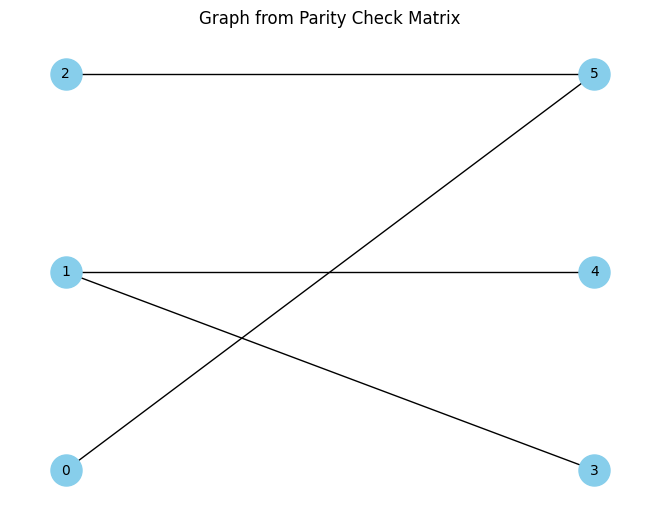

In [2]:
#The following parity check matrix is generated using Radford Neals LDPC-Codes Library
#./make-ldpc dummy 6 12 1 evenboth 3
# Use Reptition Code Parity CHeck Matrix
bigger_binary_string = """ 1 0 1 1 0 0 1 0 1 0 0 1
                    0 1 1 0 0 1 1 1 0 0 0 1
                    0 1 0 1 1 1 0 0 1 1 0 0
                    1 1 1 0 1 0 0 0 1 0 1 0
                    0 0 0 0 0 1 1 1 0 1 1 1
                    1 0 0 1 1 0 0 1 0 1 1 0"""

big_binary_string = """ 0 1 0 1 0 0
                    1 1 0 0 0 0
                    1 0 1 0 1 1 """

binary_string = """   0 1 0 
                            0 1 0 
                            1 0 1  """
H = np.array([[int(bit) for bit in line.split()] for line in binary_string.split('\n')])
print(scipy.sparse.issparse(H))

# Create a bipartite graph
G = nx.Graph()

# Determine the dimensions of the parity check matrix
num_checks, num_vars = H.shape

# Create variable nodes and check nodes
variable_nodes = list(range(num_vars))
check_nodes = list(range(num_vars, num_vars + num_checks))

# Add nodes to the graph
G.add_nodes_from(variable_nodes, bipartite=0)  # Variable nodes
G.add_nodes_from(check_nodes, bipartite=1)     # Check nodes

# Add edges between variable and check nodes based on the parity check matrix
for i in range(num_checks):
    for j in range(num_vars):
        if H[i, j] == 1:
            G.add_edge(j, num_vars + i)


pos = nx.bipartite_layout(G, variable_nodes)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black')
plt.title("Graph from Parity Check Matrix")
plt.show()

40
40
80


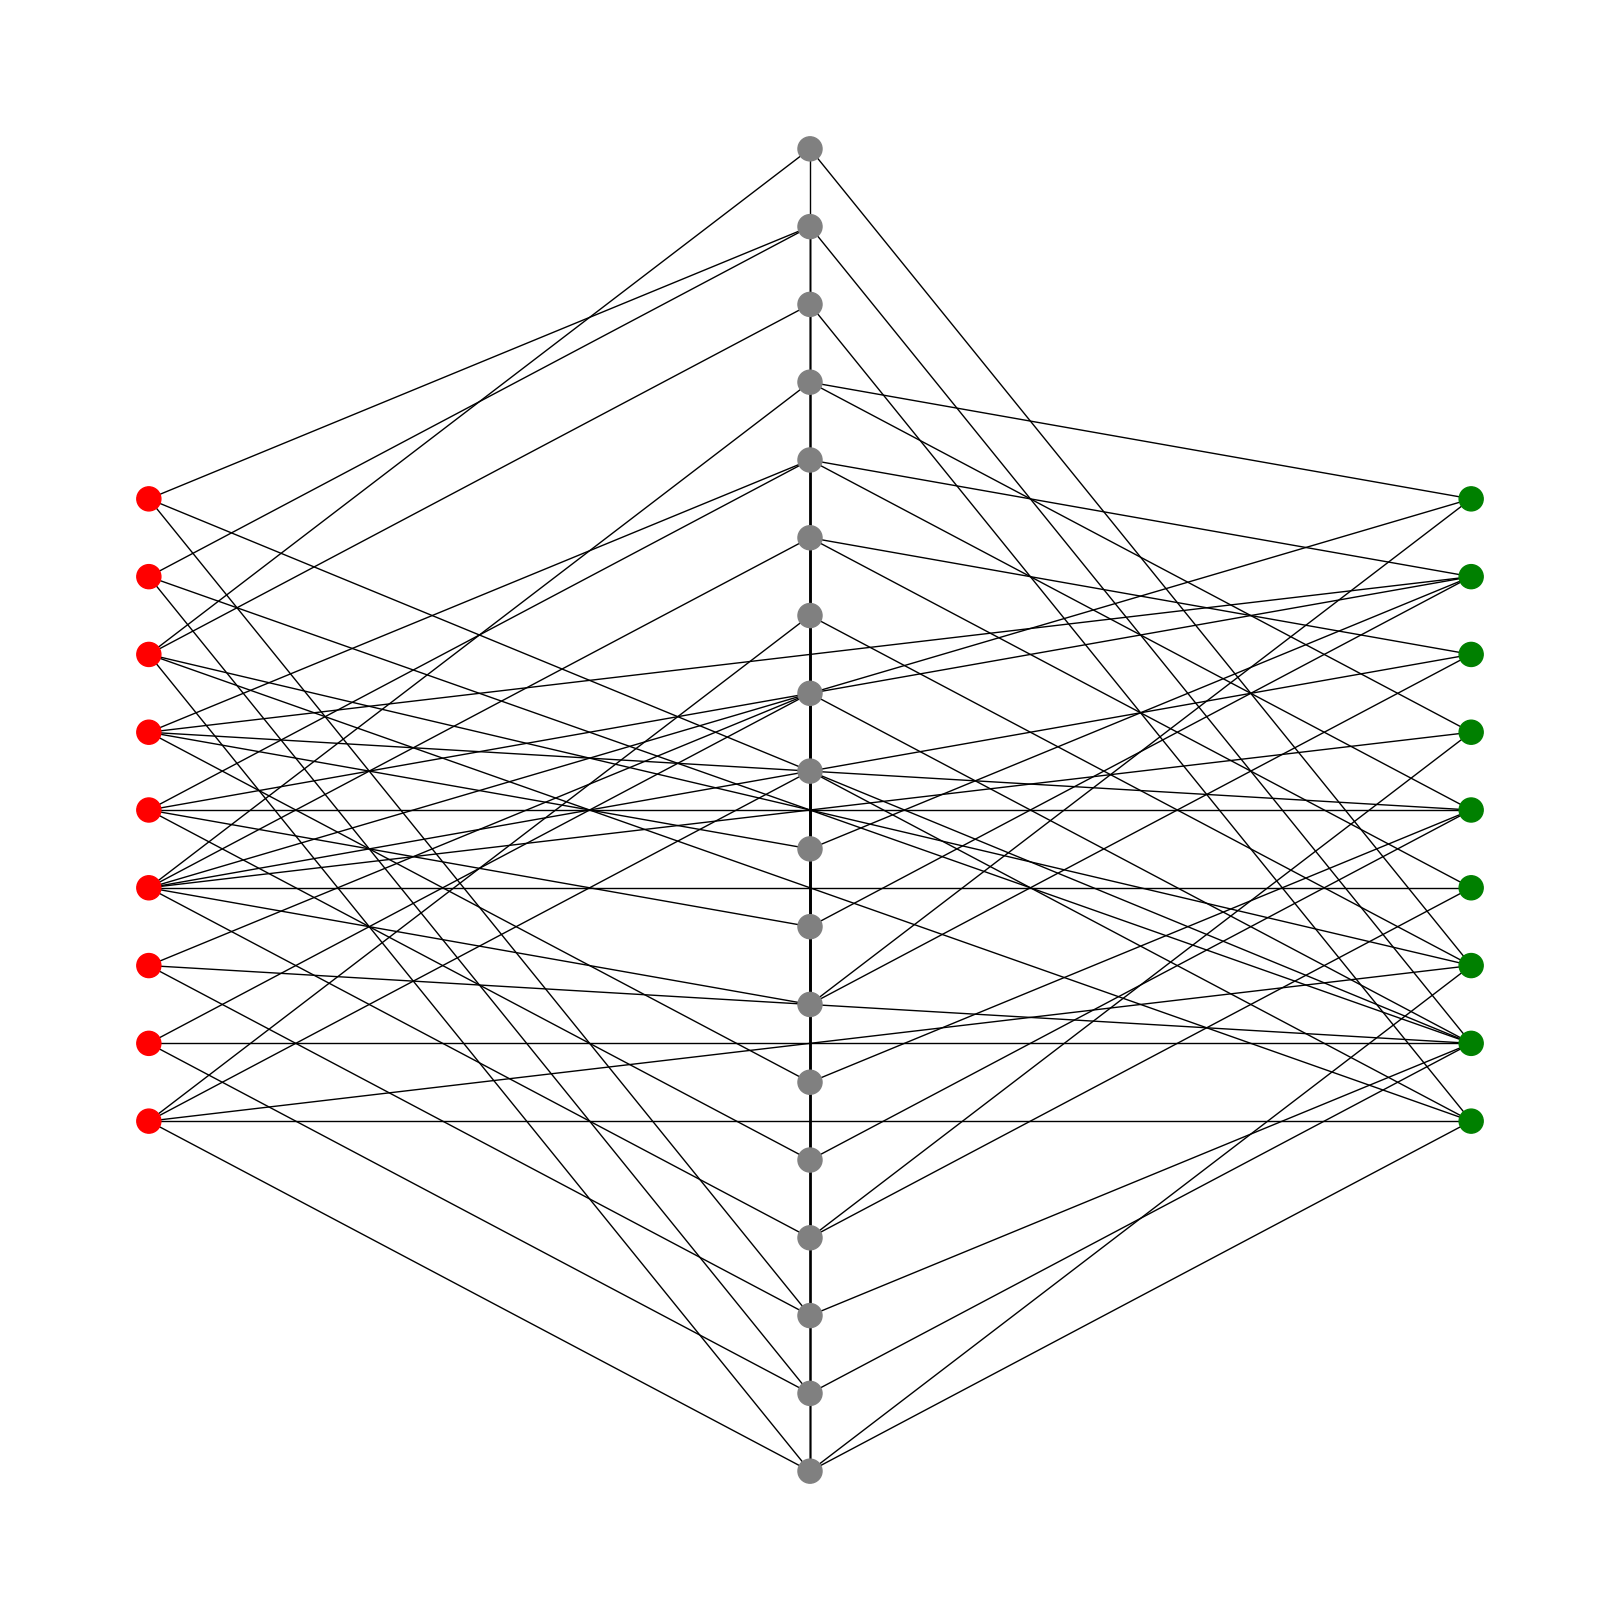

In [4]:
#Code to Construct QLDPC Code From LDPC Code Following Construction given by Tillich and Zemor

#cartesian Product
def cp(a : list[int], b : list[int]):
    res = []
    for i in a:
        for j in b:
            res.append((i,j))
    return res

VxC = cp(variable_nodes,check_nodes)
CxV = cp(check_nodes,variable_nodes) 
VxVuCxC = cp(variable_nodes,variable_nodes) + cp(check_nodes,check_nodes)
Q = nx.strong_product(G,G)
print(len(Q.edges(VxC)))
print(len(Q.edges(CxV)))
print(len(Q.edges))
#Constructing the tripartiteGraph
subset_sizes = [len(VxC) , len(Q.nodes()) - 2*len(VxC), len(CxV)]
subset_color = ["red", "grey", "green"]
HP = nx.Graph()
HP.add_nodes_from(VxC, layer=0)
HP.add_nodes_from(VxVuCxC, layer=1)
HP.add_nodes_from(CxV, layer=2)
HP.add_edges_from(Q.edges)
color = [subset_color[data["layer"]] for v, data in HP.nodes(data=True)]
pos = nx.multipartite_layout(HP, subset_key="layer")
plt.figure(figsize=(16, 16))
nx.draw(HP, pos, node_color=color, with_labels=False)
plt.show()


In [7]:

def run_basic_sim(HP,VxC,CxV,VxVuCxC,n,rounds):
    Qubits = {i:list(HP.nodes)[i] for i in range(len(HP.nodes))}
    is_x_check = lambda i : Qubits[i] in VxC
    is_z_check = lambda i : Qubits[i] in CxV
    is_basic = lambda i : Qubits[i] in VxVuCxC
    is_connected = lambda i,j : (Qubits[i],Qubits[j]) in list(HP.edges)
    mcnt=0
    full_circuit = stim.Circuit()
    for i in Qubits:
        if is_basic(i):
            full_circuit.append("M", i)
    circuit = stim.Circuit()
    for i in Qubits:
        if is_basic(i):
            circuit.append("X_ERROR", i, 0.001)
    for i in Qubits:
        if is_basic(i):
            circuit.append("Z_ERROR", i, 0.001)
    for i in Qubits:
        if is_basic(i):
            circuit.append("H", [i])
    for i in Qubits:
        if is_basic(i):
            circuit.append("DEPOLARIZE1", [i],0.001)
    for i in Qubits:
        if is_x_check(i):
            for j in Qubits:
                if is_basic(j) and is_connected(i,j):
                    circuit.append("CNOT", [i,j])
    for i in Qubits:
        if is_x_check(i):
            for j in Qubits:
                if is_basic(j) and is_connected(i,j):
                    circuit.append("DEPOLARIZE2", [j,i], 0.001)       
    for i in Qubits:
        if is_basic(i):
            circuit.append("H", [i])
    for i in Qubits:
        if is_basic(i):
            circuit.append("DEPOLARIZE1", [i],0.001)
    for i in Qubits:
        if is_z_check(i):
            for j in Qubits:
                if is_basic(j) and is_connected(j,i):
                    circuit.append("CNOT", [j,i])
    for i in Qubits:
        if is_z_check(i):
            for j in Qubits:
                if is_basic(j) and is_connected(j,i):
                    circuit.append("DEPOLARIZE2", [j,i], 0.01)
    for i in Qubits:
        if is_z_check(i) or is_x_check(i):
            circuit.append_operation("MR",i)  
            mcnt+=1

    full_circuit+=circuit*rounds
    for i in Qubits:
        if is_basic(i):
            full_circuit.append("M", i)
    print(full_circuit)
    m =full_circuit.compile_sampler().sample(n)
    return sum([sum([m[j][0:len(VxVuCxC)][i] != m[j][-len(VxVuCxC):][i] for i in range(len(VxVuCxC))])/len(VxVuCxC) for j in range(n)])/n

In [8]:
run_basic_sim(HP,VxC,CxV,VxVuCxC,n=100000,rounds=5)

M 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
REPEAT 5 {
    X_ERROR(0.001) 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
    Z_ERROR(0.001) 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
    H 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
    DEPOLARIZE1(0.001) 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
    CX 0 10 0 24 1 10 1 25 2 9 2 11 2 26 3 13 3 18 3 21 4 13 4 19 4 22 5 12 5 14 5 20 5 23 6 16 6 24 7 16 7 25 8 15 8 17 8 26
    DEPOLARIZE2(0.001) 10 0 24 0 10 1 25 1 9 2 11 2 26 2 13 3 18 3 21 3 13 4 19 4 22 4 12 5 14 5 20 5 23 5 16 6 24 6 16 7 25 7 15 8 17 8 26 8
    H 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
    DEPOLARIZE1(0.001) 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
    CX 12 27 20 27 13 28 18 28 19 28 14 29 20 29 12 30 23 30 13 31 21 31 22 31 14 32 23 32 9 33 15 33 26 33 10 34 16 34 24 34 25 34 11 35 17 35 26 35
    DEPOLARIZE2(0.01) 12 27 20 27 13 28 18 28 19 28 14 29 20 29 12 30 23 30 13 31 21 31 22 31 14 32 23

0.04811888888893475

324
180


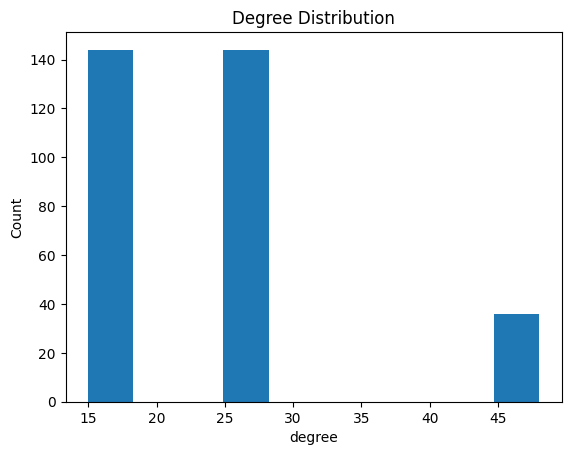

In [350]:
keys = list(HP.nodes)
keys.sort(key= HP.degree)
degrees = list(map(HP.degree, keys))
plt.hist(degrees)
plt.title("Degree Distribution")
plt.xlabel("degree")
plt.ylabel("Count")

print(len(HP.nodes))
print(len(VxVuCxC))

In [ ]:
class NeutralAtom:
    def __init__(self,n,locs):
        self.x = {i:i for i in range(n)}
        self.y = {i:i for i in range(n)}
        self.locs = locs
    def disp(self):
        figure, axes = plt.subplots()
        for x in self.x:
            for y in self.y:
               axes.add_artist(plt.Circle((self.x[x],self.y[y]),0.05, color="red"))
        for loc in self.locs:
            axes.add_artist(plt.Circle(loc, 0.05, color="green"))
        axes.set_aspect( 1 )
        plt.xlim(-1,len(self.x))
        plt.ylim(-1,len(self.x))
        plt.title( 'Colored Circle' )
        figure.set_size_inches(16,16)
        plt.show()
    def move_row(self,row,delta_y):
        self.y[row]+=delta_y
    def move_col(self,col,delta_x):
        self.x[col]+=delta_x

myMachine = NeutralAtom(5,[(0.5,0.5)])
myMachine.disp()
myMachine.move_row(0,0.25)
myMachine.disp()
myMachine.move_col(0,0.25)
myMachine.disp()

In [299]:
min([HP.degree(i) for i in HP.nodes])

3

# Considerations

1. Original Layout

    a. what size grid should be used

    b. Where should the static qubits go

2. Assignment of Qubits to Qubits

    a. What assignment will enable the scheduler to do the best job
    
3. Scheduling

    a. given an assignment how should scheduling happen to minimize circuit depth

# Implementing Various Error correcting codes in STIM

## The Repition Code

In [9]:
import stim

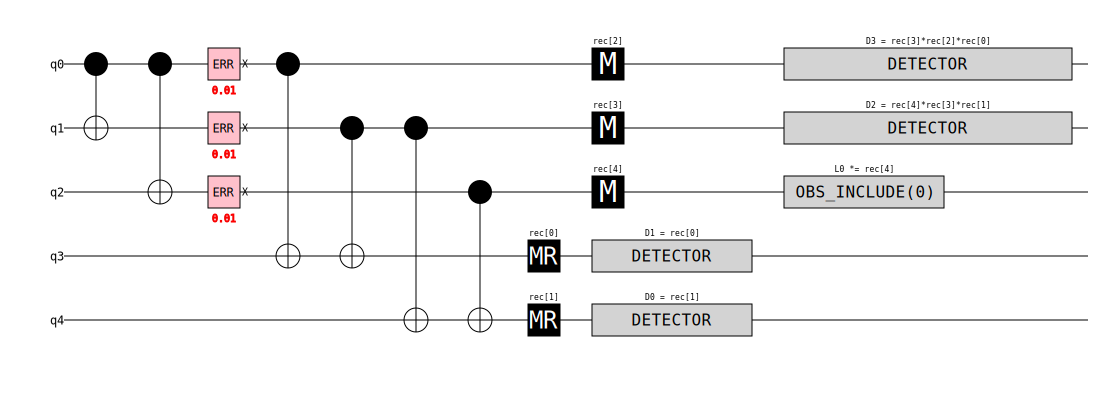

In [167]:
circuit = stim.Circuit()




#Encoding
circuit.append("CNOT", [0, 1])
circuit.append("CNOT", [0, 2])

#Errors
circuit.append("X_ERROR", [0,1,2], 0.01)

#Syndrome Extraction
#Measuring the first Observable 
circuit.append("CNOT", [0,3,1,3,1,4,2,4])
circuit.append("MR", [3,4]) #
circuit.append("Detector", stim.target_rec(-1))
circuit.append("Detector", stim.target_rec(-2))
circuit.append("M", [0,1,2])
circuit.append("Detector", [stim.target_rec(-1),stim.target_rec(-2), stim.target_rec(-4)])
circuit.append("Detector", [stim.target_rec(-2),stim.target_rec(-3), stim.target_rec(-5)])
circuit.append("OBSERVABLE_INCLUDE", stim.target_rec(-1), 0.)
circuit.diagram('timeline-svg')

In [168]:

#Compile the circuit for simulation
sampler = circuit.compile_sampler()
print(sampler.sample(shots = 100))

[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [ True False  True False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [ True False  True False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [ True False  True False False]
 [False Fa

In [169]:
detector_sampler = circuit.compile_detector_sampler()
sample = detector_sampler.sample(shots=12)
for i in sample:
    print("".join("!" if e else "_" for e in i))

____
____
____
____
____
____
____
____
_!__
____
____
____


stim.DetectorErrorModel('''
    error(0.01) D0 D1
    error(0.01) D0 L0
    error(0.01) D1
    detector D2
    detector D3
''')


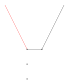

In [170]:
dem =  circuit.detector_error_model()
print(repr(dem))
dem.diagram("matchgraph-svg")

In [217]:
import pymatching

In [223]:
def make_circuit(p):
    circuit = stim.Circuit()

    #Encoding
    circuit.append("CNOT", [0, 1])
    circuit.append("CNOT", [0, 2])

    #Errors
    circuit.append("DEPOLARIZE1", [0,1,2], p)

    #Syndrome Extraction
    #Measuring the first Observable 
    circuit.append("CNOT", [0,3,1,3,1,4,2,4])
    circuit.append("MR", [3,4]) #
    circuit.append("Detector", stim.target_rec(-1))
    circuit.append("Detector", stim.target_rec(-2))
    circuit.append("M", [0,1,2])
    circuit.append("Detector", [stim.target_rec(-1),stim.target_rec(-2), stim.target_rec(-4)])
    circuit.append("Detector", [stim.target_rec(-2),stim.target_rec(-3), stim.target_rec(-5)])
    circuit.append("OBSERVABLE_INCLUDE", stim.target_rec(-1), 0.)
    circuit.diagram('timeline-svg')
    return circuit




def count_logical_errors(make_circuit, p, num_shots: int) -> int:
    # Sample the circuit.
    circuit = make_circuit(p)
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors/num_shots

In [224]:
num_shots = 100_000
num_logical_errors = count_logical_errors(make_circuit, 0.01, num_shots)
logical_error_rate = num_logical_errors/num_shots
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 0.00013 wrong predictions (logical errors) out of 100000 shots


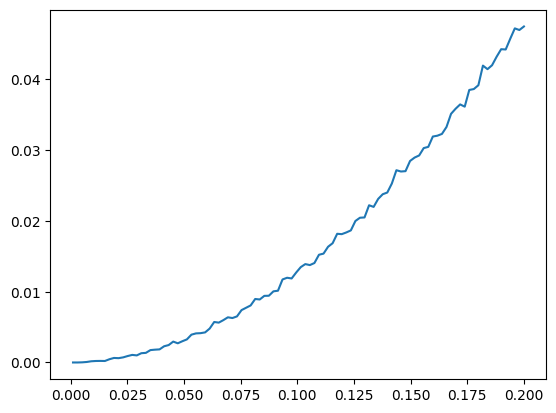

In [225]:
physical_e = np.linspace(0.001, 0.2, 100)
logical_e = [count_logical_errors(make_circuit, e, 100_000) for e in physical_e]
plt.plot(physical_e,logical_e)

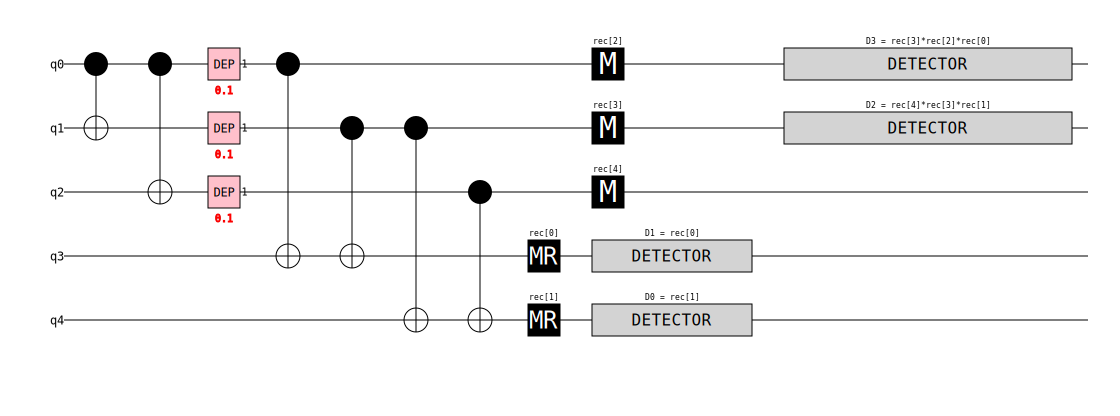

In [216]:
c = make_circuit(0.1)
c.diagram("timeline-svg")

# 11/07 Attempt again!




In [226]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=2,
    distance=3,
    after_reset_flip_probability=0.001)

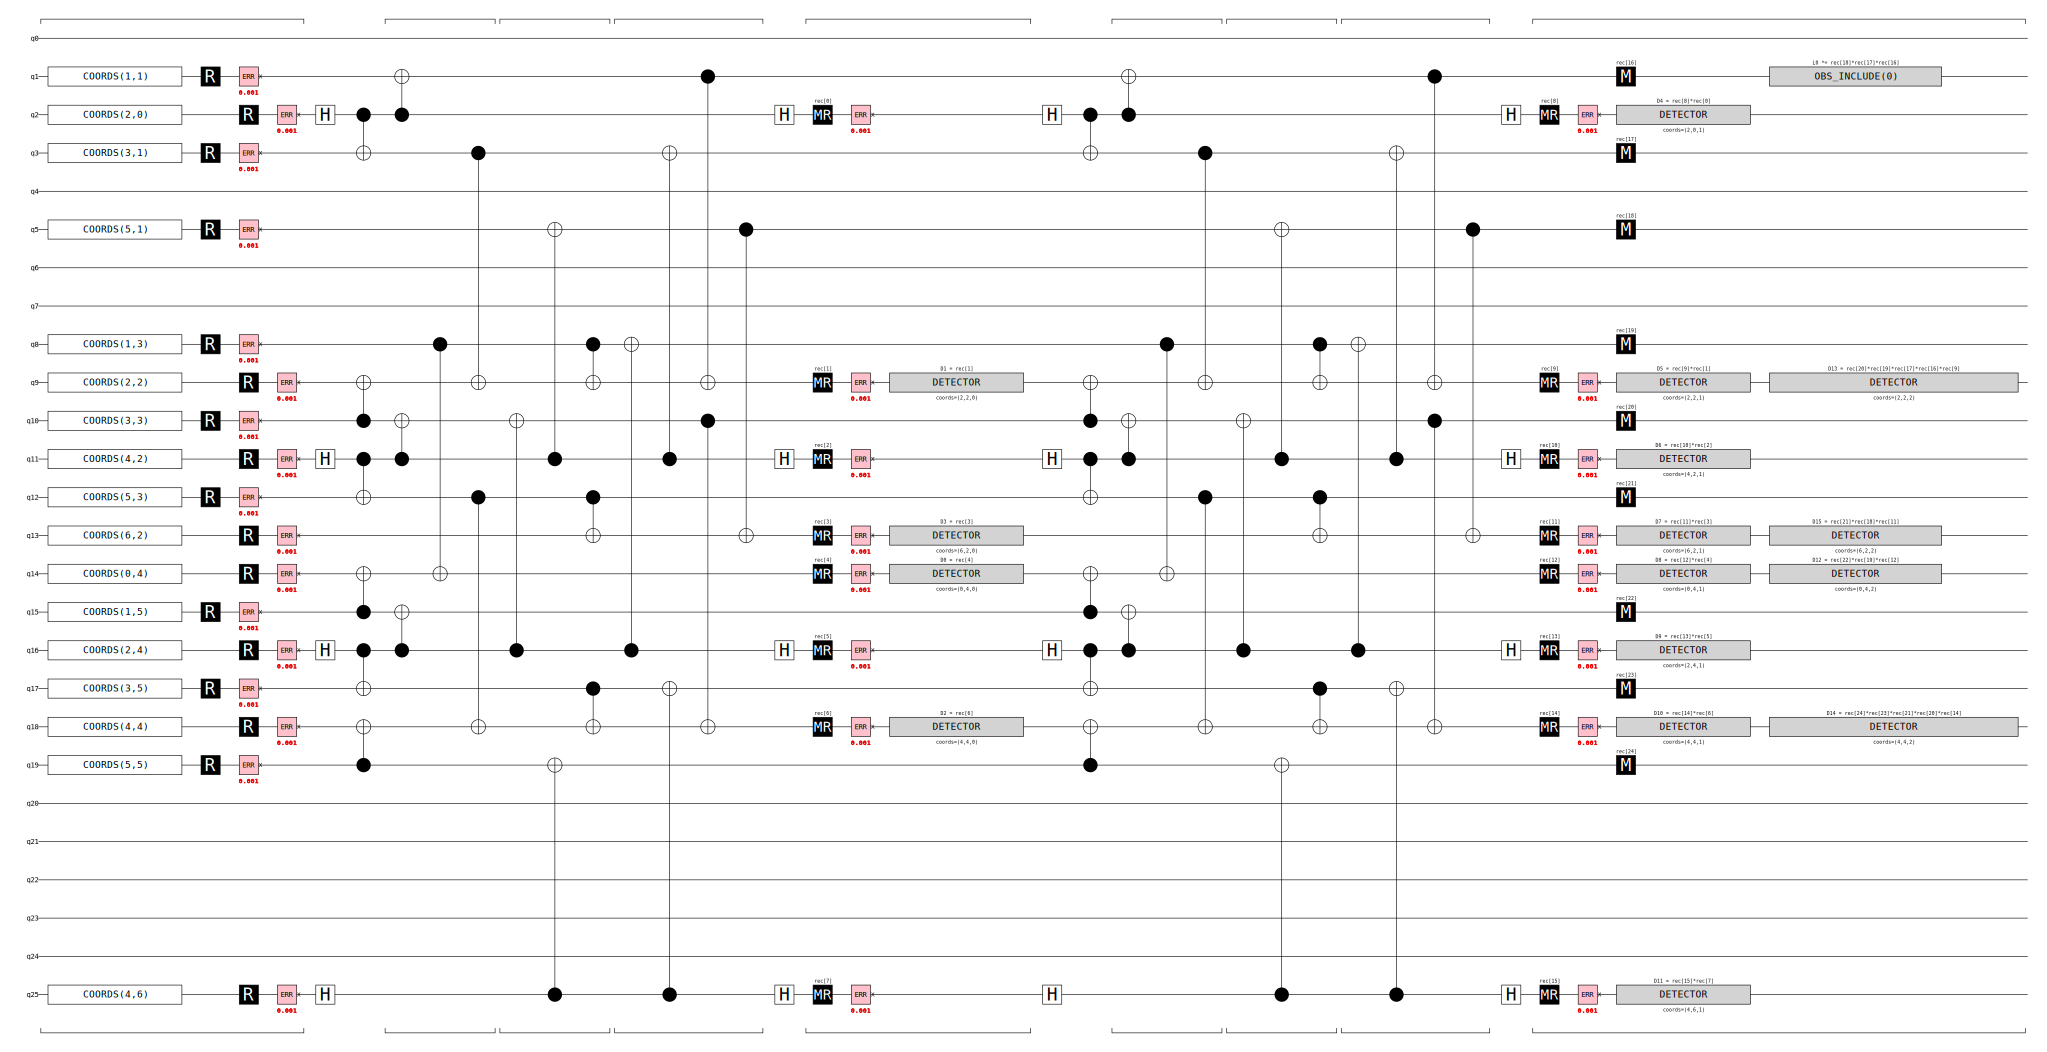

In [227]:
surface_code_circuit.diagram("timeline-svg") 

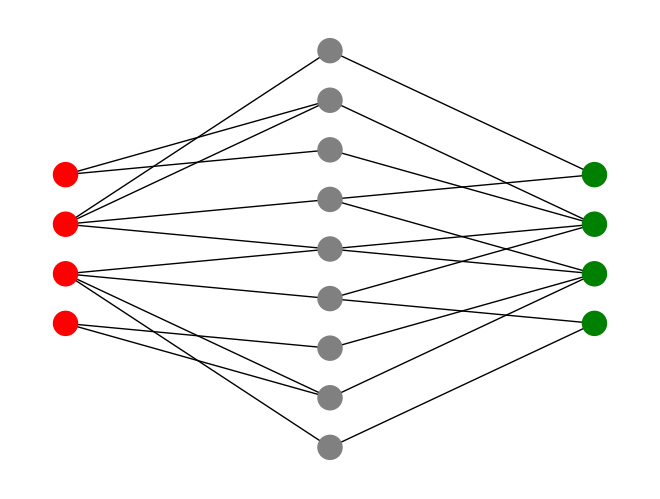

In [870]:
import networkx as nx
import stim
# Code to create the graph for the surface code

data_nodes = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
]

x_stabilizers = [
    9,
    11,
    14,
    16
]

z_stabilizers = [
    10,
    12,
    13,
    15
]

edges = [
    #X_edges
    (1,9), (2,9),
    (0,11), (1,11), (3,11), (4,11),
    (4,14), (5,14), (7,14), (8,14),
    (6,16), (7,16),

    #z_edges
    (0,10), (3,10),
    (2,12), (1,12), (5,12), (4,12),
    (4,13), (3,13), (7,13), (6,13),
    (5,15), (8,15)
]

graph = nx.Graph()
graph.add_nodes_from(data_nodes, layer = 1)
graph.add_nodes_from(x_stabilizers, layer = 0)
graph.add_nodes_from(z_stabilizers, layer = 2)
graph.add_edges_from(edges)
color = [subset_color[data["layer"]] for v, data in graph.nodes(data=True)]
pos = nx.multipartite_layout(graph, subset_key="layer")
# plt.figure(figsize=(16, 16))
nx.draw(graph, pos, node_color=color, with_labels=False)
plt.show()

def make_circuit(data_nodes, x_stabilizers, z_stabilizers,rounds, error_arr):
    circuit = stim.Circuit()
    for node in data_nodes, x_stabilizers, z_stabilizers:
        circuit.append('R', node)
    #Syndrome Extraction
    circuit.append('TICK')
    for edge in edges:
        if edge[1] in z_stabilizers:
            circuit.append('CX', [edge[0], edge[1]])
    for node in x_stabilizers:
        circuit.append('H', node)
    for edge in edges:
        if edge[1] in x_stabilizers:
            circuit.append('CX', [edge[1], edge[0]])
    for node in x_stabilizers:
        circuit.append('H', node)
    for node in z_stabilizers:
        circuit.append('MR', node)
    for  node in x_stabilizers:
        circuit.append('MR', node)
    #Error Injection
    circuit.append('TICK')
    for i in range(len(data_nodes)):
        if error_arr[i]:
            circuit.append('X_ERROR', data_nodes[i], 0.99999999999999)
    for round in range(rounds):
        for edge in edges:
            if edge[1] in z_stabilizers:
                circuit.append('CX', [edge[0], edge[1]])
        for node in x_stabilizers:
            circuit.append('H', node)
        for edge in edges:
            if edge[1] in x_stabilizers:
                circuit.append('CX', [edge[1], edge[0]])
        for node in x_stabilizers:
            circuit.append('H', node)
        circuit.append('TICK')
        for node in z_stabilizers+x_stabilizers:
            circuit.append('MR', node)
            circuit.append('DETECTOR', [stim.target_rec(-1),stim.target_rec(-len(z_stabilizers+x_stabilizers)-1)])
        circuit.append('TICK')
    #Final Measurement
    return circuit

def generate_binary_sequences(length):
    return list(itertools.product([0, 1], repeat=length))

binary_sequences = generate_binary_sequences(9)
syndrome_map = {}
for sequence in binary_sequences:
    circuit = make_circuit(data_nodes, x_stabilizers, z_stabilizers, 1, sequence)
    sample = circuit.compile_detector_sampler().sample(1)
    syndrome_map[sequence] = sample
    

In [883]:
for i in syndrome_map:
    print(f'{i}:{list((1 if i else 0 for i in syndrome_map[i][0]))}')

(0, 0, 0, 0, 0, 0, 0, 0, 0) : [0, 0, 0, 0, 0, 0, 0, 0]
(0, 0, 0, 0, 0, 0, 0, 0, 1) : [0, 0, 0, 1, 0, 0, 0, 0]
(0, 0, 0, 0, 0, 0, 0, 1, 0) : [0, 0, 1, 0, 0, 0, 0, 0]
(0, 0, 0, 0, 0, 0, 0, 1, 1) : [0, 0, 1, 1, 0, 0, 0, 0]
(0, 0, 0, 0, 0, 0, 1, 0, 0) : [0, 0, 1, 0, 0, 0, 0, 0]
(0, 0, 0, 0, 0, 0, 1, 0, 1) : [0, 0, 1, 1, 0, 0, 0, 0]
(0, 0, 0, 0, 0, 0, 1, 1, 0) : [0, 0, 0, 0, 0, 0, 0, 0]
(0, 0, 0, 0, 0, 0, 1, 1, 1) : [0, 0, 0, 1, 0, 0, 0, 0]
(0, 0, 0, 0, 0, 1, 0, 0, 0) : [0, 1, 0, 1, 0, 0, 0, 0]
(0, 0, 0, 0, 0, 1, 0, 0, 1) : [0, 1, 0, 0, 0, 0, 0, 0]
(0, 0, 0, 0, 0, 1, 0, 1, 0) : [0, 1, 1, 1, 0, 0, 0, 0]
(0, 0, 0, 0, 0, 1, 0, 1, 1) : [0, 1, 1, 0, 0, 0, 0, 0]
(0, 0, 0, 0, 0, 1, 1, 0, 0) : [0, 1, 1, 1, 0, 0, 0, 0]
(0, 0, 0, 0, 0, 1, 1, 0, 1) : [0, 1, 1, 0, 0, 0, 0, 0]
(0, 0, 0, 0, 0, 1, 1, 1, 0) : [0, 1, 0, 1, 0, 0, 0, 0]
(0, 0, 0, 0, 0, 1, 1, 1, 1) : [0, 1, 0, 0, 0, 0, 0, 0]
(0, 0, 0, 0, 1, 0, 0, 0, 0) : [0, 1, 1, 0, 0, 0, 0, 0]
(0, 0, 0, 0, 1, 0, 0, 0, 1) : [0, 1, 1, 1, 0, 0, 0, 0]
(0, 0, 0, 

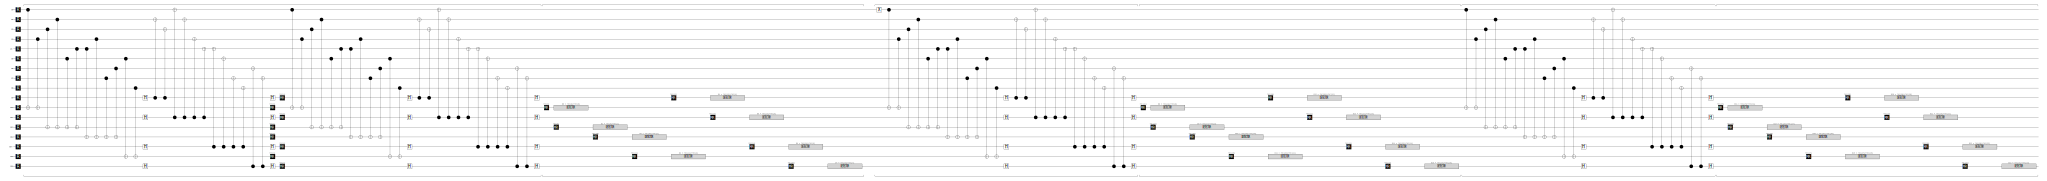

In [561]:
circuit.diagram('timeline-svg')

In [391]:
sample = circuit.compile_sampler().sample(1)
circuit.diagram('timeline-svg')
print(sample)
lst = sample[0]
for i in [lst[i:i + 8] for i in range(0, len(lst), 8)]:
    print(i)

[[False  True  True  True False False False False False False False False
  False False False False False  True  True  True False False False False
  False False False False False False False False False  True  True  True
  False False False False False False False False False False False False
  False  True  True  True False False False False False False False False
  False False False False False  True  True  True False False False False
  False False False False False False False False False  True  True  True
  False False False False False False False False False False False False
  False  True  True  True False False False False False False False False
  False False False False False  True  True  True False False False False
  False False False False False False False False False  True  True  True
  False False False False False False False False False False False False
  False  True  True  True False False False False False False False False
  False False False False False  True 

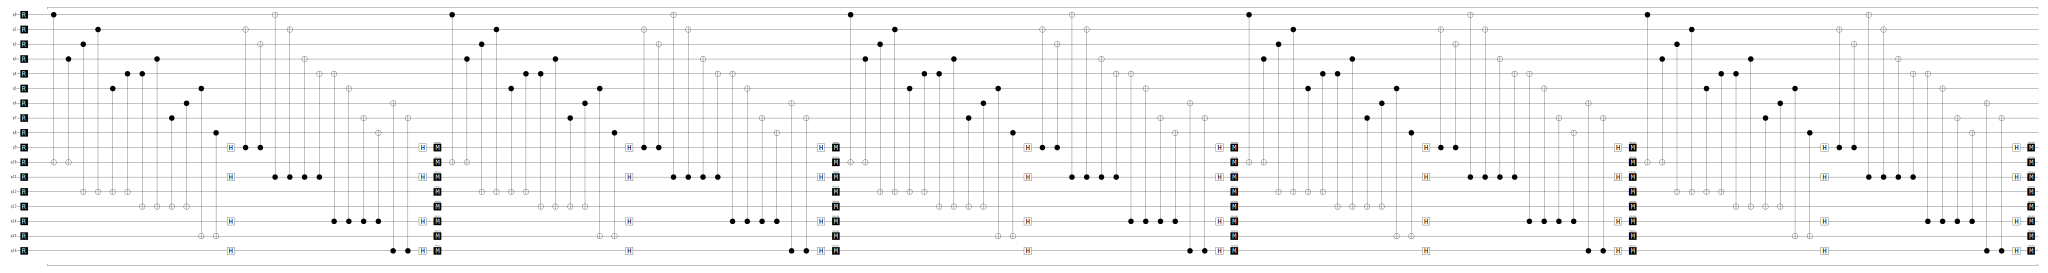

In [381]:
circuit.diagram('timeline-svg')

In [324]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=1,
    distance=3,
    after_reset_flip_probability=0.001)

In [325]:
surface_code_circuit

stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19
    X_ERROR(0.001) 1 3 5 8 10 12 15 17 19
    R 2 9 11 13 14 16 18 25
    X_ERROR(0.001) 2 9 11 13 14 16 18 25
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    MR 2 9 11 13 14 16 18 25
    X_ERROR(0.001) 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4]
    DETECTOR(2, 2, 0) rec[-7]
    DETECTOR(4, 4, 0) re

In [397]:
c = stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19
    R 2 9 11 13 14 16 18 25
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    MR 2 11 16 25 
    MR 9 13 14 18 
''')
sample = c.compile_sampler().sample(100)
print(sample)

[[ True False False False False False False False]
 [ True False  True False False False False False]
 [False False  True  True False False False False]
 [ True False  True  True False False False False]
 [False False  True False False False False False]
 [False  True False False False False False False]
 [False False False False False False False False]
 [False False  True  True False False False False]
 [ True False  True  True False False False False]
 [ True  True False False False False False False]
 [False False  True False False False False False]
 [ True  True  True False False False False False]
 [False False  True False False False False False]
 [False False False  True False False False False]
 [False False  True  True False False False False]
 [ True False  True  True False False False False]
 [ True  True False  True False False False False]
 [False  True False False False False False False]
 [ True False  True False False False False False]
 [ True  True False False False

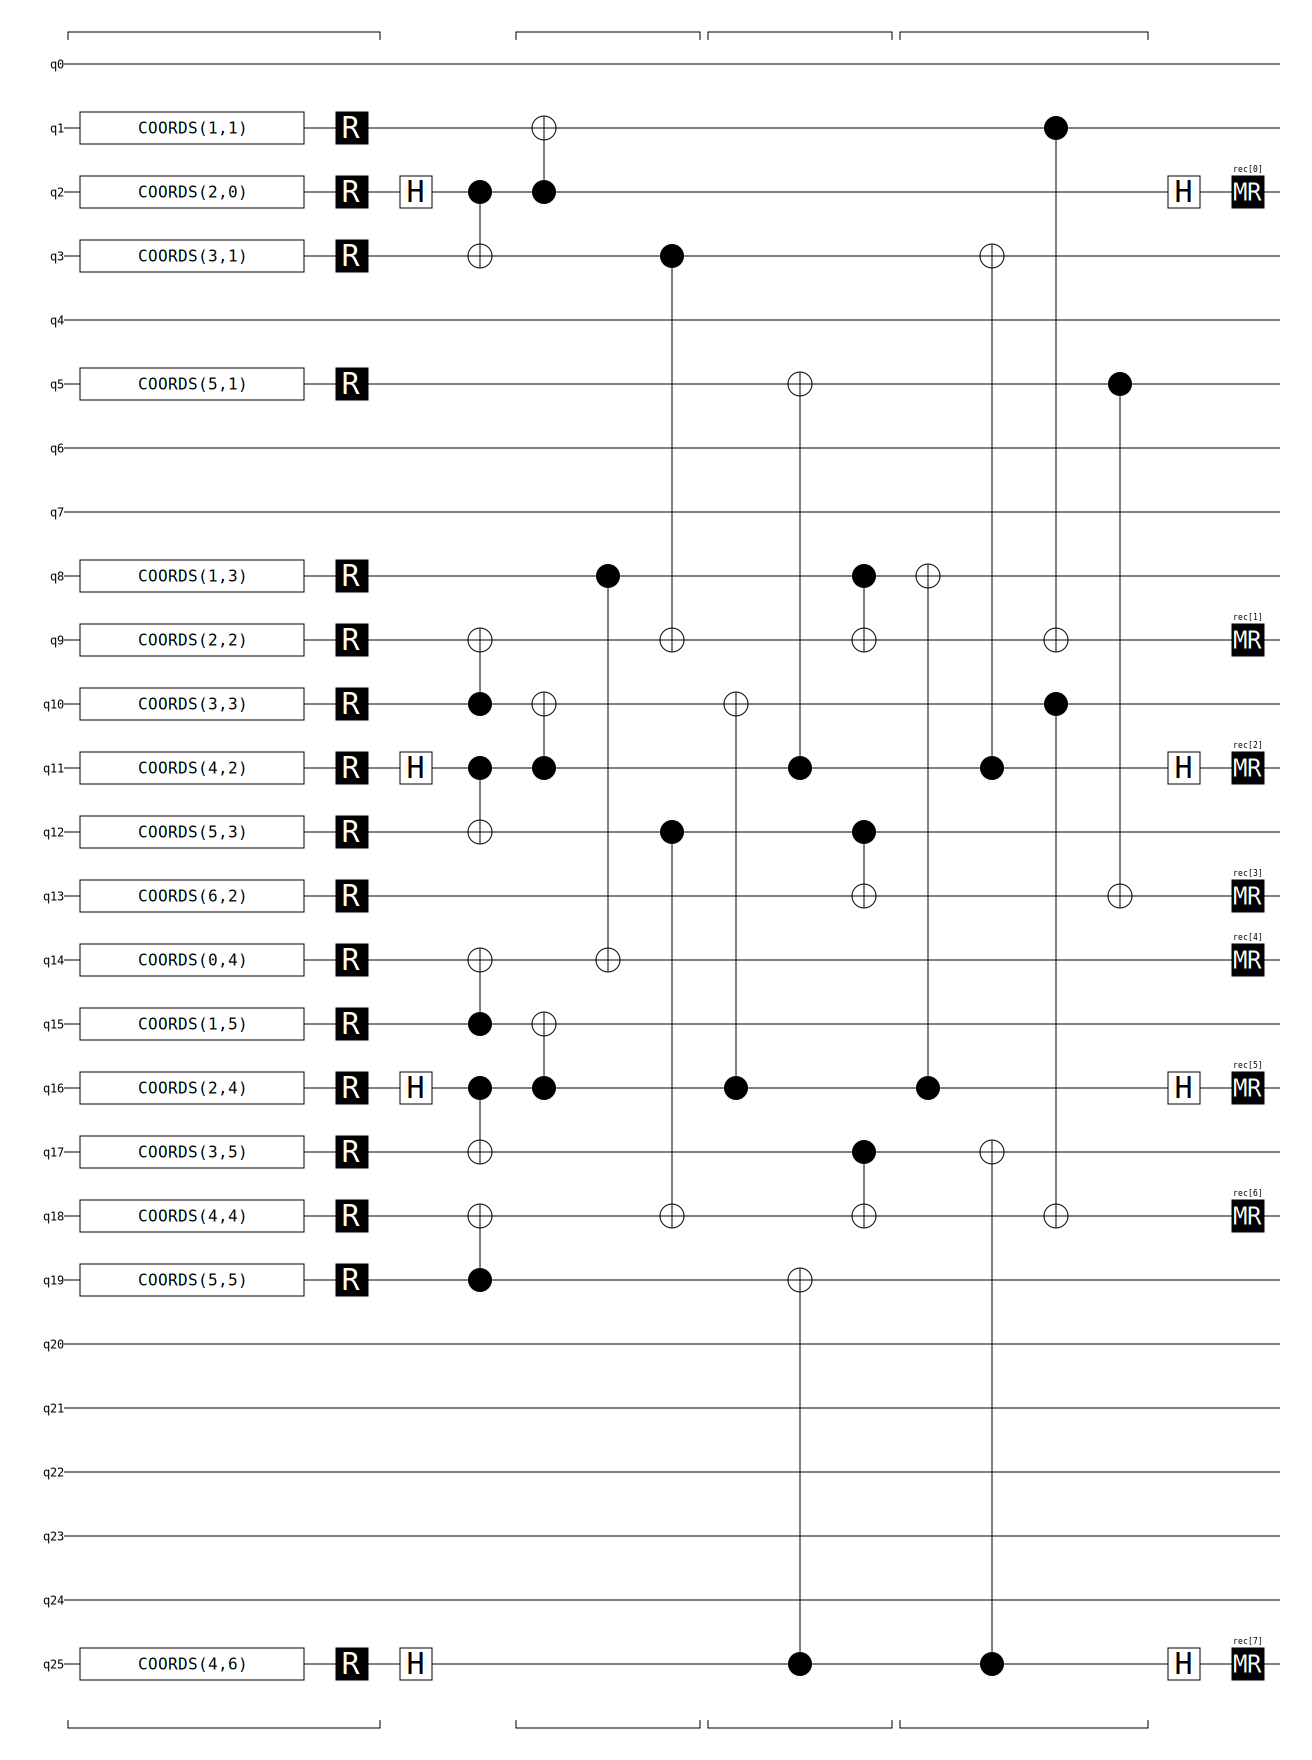

In [329]:

sample = c.compile_sampler().sample(100)
print(sample)

In [393]:
cz = c
sample = cz.compile_sampler().sample(100)
print(sample)

[[False False  True False False  True  True False]
 [ True  True False  True  True False False False]
 [False  True  True  True False  True  True  True]
 [ True  True  True  True False False False  True]
 [ True  True False False  True  True  True  True]
 [ True False  True False  True False  True False]
 [ True False False False  True  True False  True]
 [ True  True False  True False False False False]
 [False  True False  True False  True  True False]
 [False  True False  True False False False False]
 [ True  True False False  True False  True False]
 [ True  True False False False False  True  True]
 [ True False False False  True False False False]
 [ True False  True  True  True False  True False]
 [False  True  True  True False  True  True False]
 [ True  True False False  True False False  True]
 [ True False  True  True False  True  True  True]
 [ True  True  True  True False  True False  True]
 [ True False  True False  True False  True  True]
 [False  True False False False

In [394]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_x",
    rounds=1,
    distance=3,
    after_reset_flip_probability=0.001)

In [352]:
surface_code_circuit

stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    RX 1 3 5 8 10 12 15 17 19
    Z_ERROR(0.001) 1 3 5 8 10 12 15 17 19
    R 2 9 11 13 14 16 18 25
    X_ERROR(0.001) 2 9 11 13 14 16 18 25
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    MR 2 9 11 13 14 16 18 25
    X_ERROR(0.001) 2 9 11 13 14 16 18 25
    DETECTOR(2, 0, 0) rec[-8]
    DETECTOR(2, 4, 0) rec[-3]
    DETECTOR(4, 2, 0) r

In [375]:
cx = stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    RX 1 3 5 8 10 12 15 17 19
    R 2 9 11 13 14 16 18 25
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    MR 2 11 16 25 9 13 14 18 
''')

In [376]:
sample = cx.compile_sampler().sample(100)
print(sample)

[[False False False False False False  True  True]
 [False False False False  True  True False False]
 [False False False False  True False  True  True]
 [False False False False False  True False False]
 [False False False False False False  True  True]
 [False False False False  True  True  True  True]
 [False False False False False  True False False]
 [False False False False False False False False]
 [False False False False  True False False  True]
 [False False False False  True  True False False]
 [False False False False False False False False]
 [False False False False False  True False False]
 [False False False False False False  True  True]
 [False False False False False False  True  True]
 [False False False False False  True False False]
 [False False False False False False False False]
 [False False False False False  True False  True]
 [False False False False  True False False False]
 [False False False False False  True False  True]
 [False False False False  True

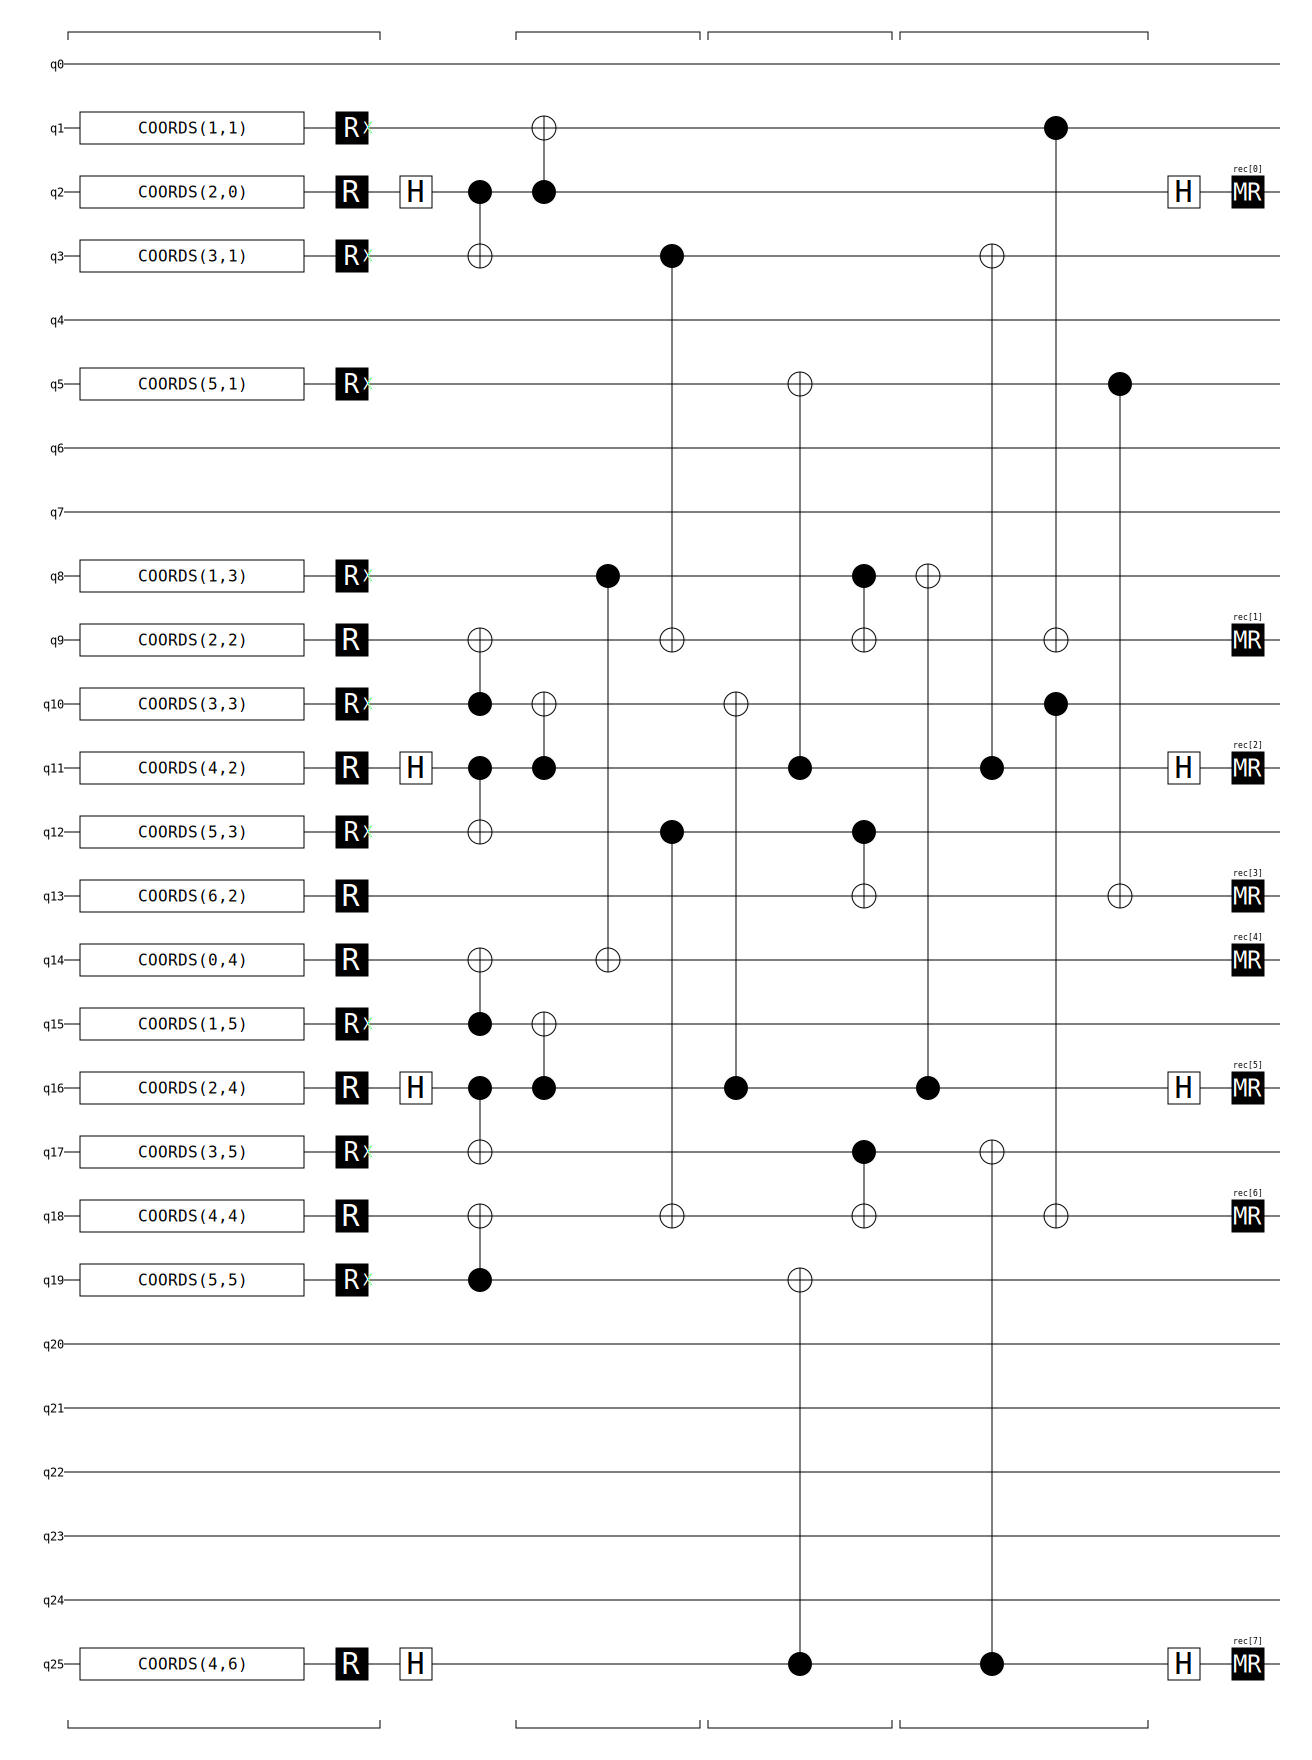

In [355]:
cx.diagram('timeline-svg')

In [564]:
from stimcircuits.surface_code import generate_circuit

circuit = generate_circuit(
    code_task= "surface_code:rotated_memory_x",
    rounds=8,
    distance=3,
    after_reset_flip_probability = 0.01
)
circuit.diagram('timeline-svg')
sample = circuit.compile_detector_sampler().sample(20)
for r in range(20):
    [0 if i else 1 for i in sample[r]]
    circuit.diagram('timeline-svg')
    lst = sample[r]
    for i in [lst[i:i + 8] for i in range(0, len(lst), 8)]:
        print(i)
    print("------------------------------------------------")

[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False  True False False False False]
[False False False  True False False False False]
------------------------------------------------
[ True False  True False False False False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
[False False False False False False False False]
------------------------------------------------
[False False False False False False False False]
[False False False False False False False False]
[F

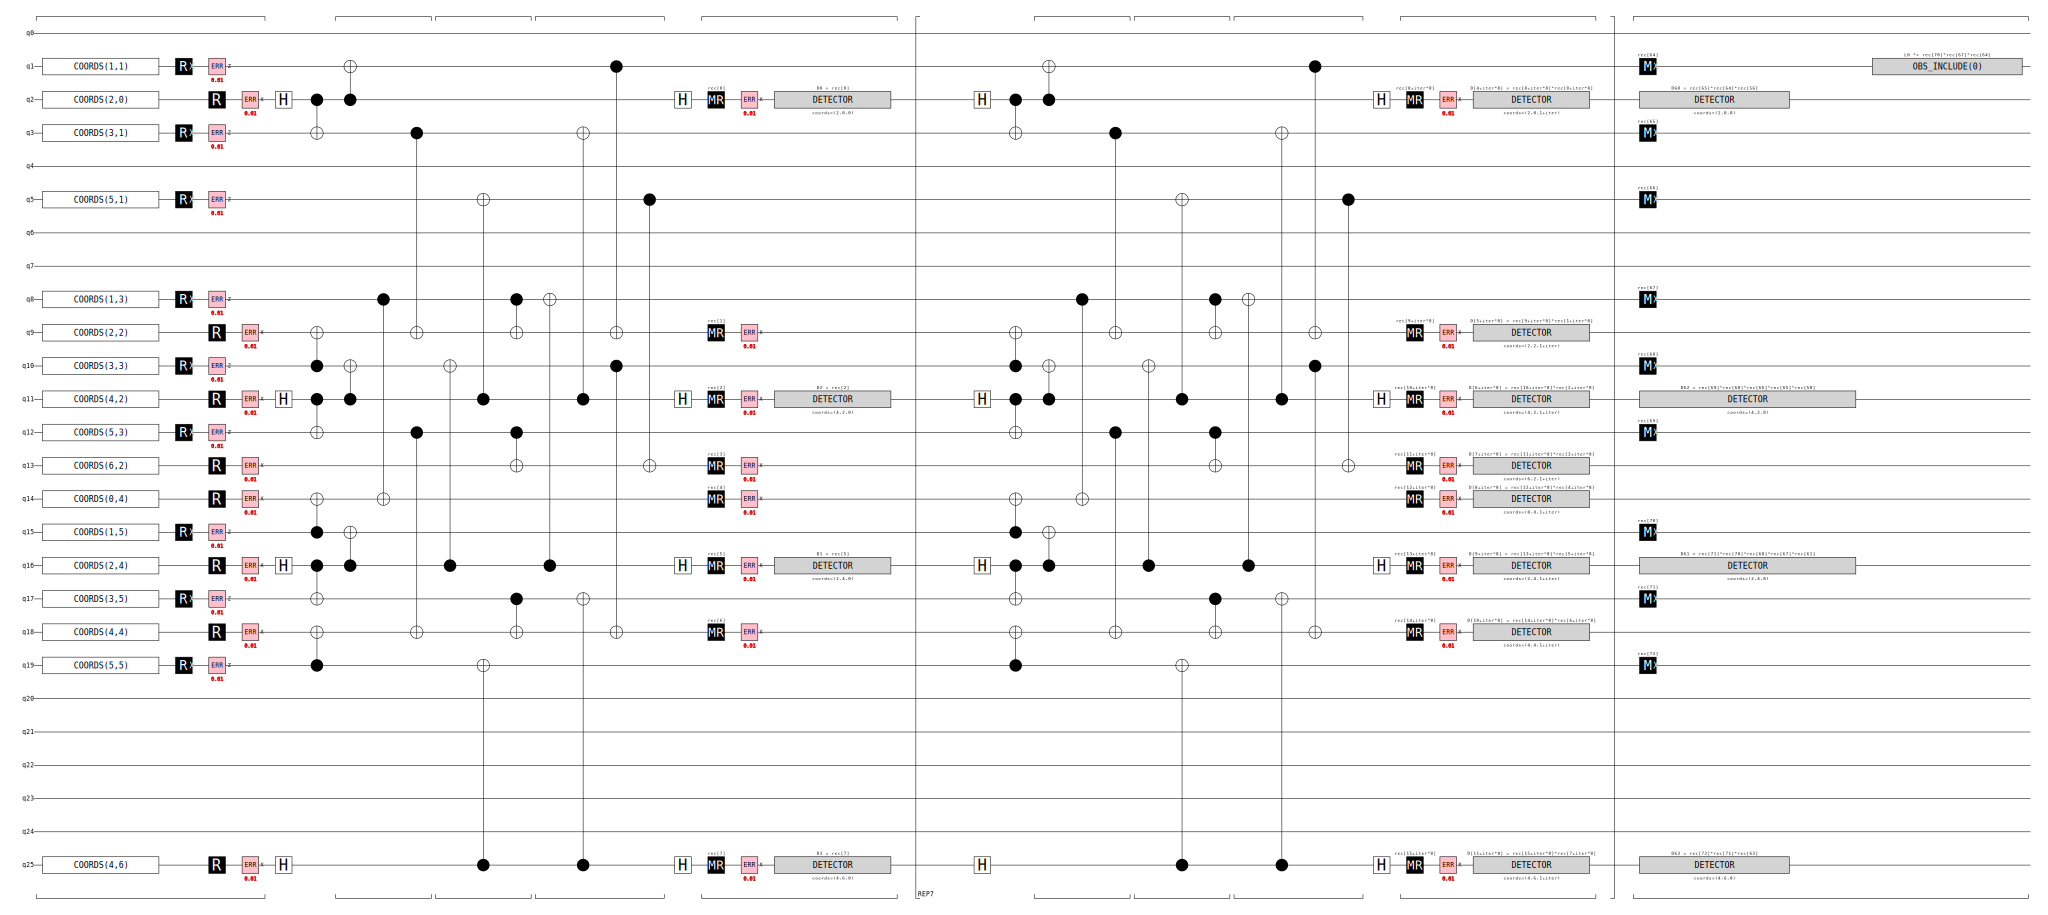

In [532]:
circuit.diagram('timeline-svg')

In [833]:
circuit = generate_circuit(
    code_task= "surface_code:rotated_memory_x",
    rounds=2,
    distance=2,
    after_reset_flip_probability = 1
)
circuit

stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(1, 3) 6
    QUBIT_COORDS(2, 2) 7
    QUBIT_COORDS(3, 3) 8
    QUBIT_COORDS(2, 4) 12
    RX 1 3 6 8
    Z_ERROR(1) 1 3 6 8
    R 2 7 12
    X_ERROR(1) 2 7 12
    TICK
    H 2 12
    TICK
    CX 2 3 8 7
    TICK
    CX 2 1 3 7
    TICK
    CX 12 8 6 7
    TICK
    CX 12 6 1 7
    TICK
    H 2 12
    TICK
    MR 2 7 12
    X_ERROR(1) 2 7 12
    DETECTOR(2, 0, 0) rec[-3]
    DETECTOR(2, 4, 0) rec[-1]
    TICK
    H 2 12
    TICK
    CX 2 3 8 7
    TICK
    CX 2 1 3 7
    TICK
    CX 12 8 6 7
    TICK
    CX 12 6 1 7
    TICK
    H 2 12
    TICK
    MR 2 7 12
    X_ERROR(1) 2 7 12
    SHIFT_COORDS(0, 0, 1)
    DETECTOR(2, 0, 0) rec[-3] rec[-6]
    DETECTOR(2, 2, 0) rec[-2] rec[-5]
    DETECTOR(2, 4, 0) rec[-1] rec[-4]
    MX 1 3 6 8
    DETECTOR(2, 0, 1) rec[-3] rec[-4] rec[-7]
    DETECTOR(2, 4, 1) rec[-1] rec[-2] rec[-5]
    OBSERVABLE_INCLUDE(0) rec[-2] rec[-4]
''')

In [803]:
c = stim.Circuit('''
    R 1 
    M 1                             
    X 1
    M 1 
    X 1
    M 1 
    DETECTOR rec[-1] rec[-3]
''')

sample = c.compile_detector_sampler().sample(40)
for r in range(20):
    circuit.diagram('timeline-svg')
    lst = sample[r]
    print(lst)


[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


In [669]:
sample = c.compile_detector_sampler().sample(20)
for r in range(1):
    circuit.diagram('timeline-svg')
    lst = sample[r]
    print(lst)
    print("------------------------------------------------")


[False False False False]
------------------------------------------------


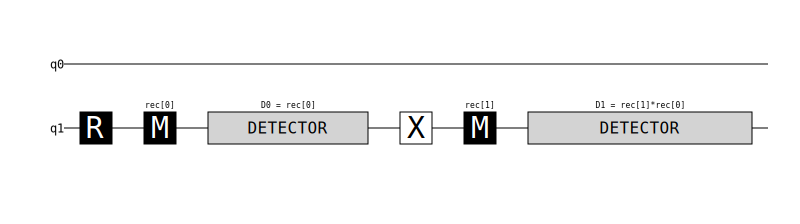

In [781]:
c.diagram('timeline-svg')

In [844]:
c = stim.Circuit('''
    R 1
    M 1
    DETECTOR rec[-1]
    X 1 
    M 1
    DETECTOR rec[-1]
''')
sample = c.compile_detector_sampler().sample(20)
print(sample)

[[False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]
 [False False]]


In [834]:
sample = circuit.compile_detector_sampler().sample(20)
print(sample)

[[ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]
 [ True  True False False False  True  True]]


In [867]:
import itertools

def generate_binary_sequences(length):
    return list(itertools.product([0, 1], repeat=length))
binary_sequences = generate_binary_sequences(8)
for sequence in binary_sequences:
    print(sequence)


(0, 0, 0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 1)
(0, 0, 0, 0, 0, 0, 1, 0)
(0, 0, 0, 0, 0, 0, 1, 1)
(0, 0, 0, 0, 0, 1, 0, 0)
(0, 0, 0, 0, 0, 1, 0, 1)
(0, 0, 0, 0, 0, 1, 1, 0)
(0, 0, 0, 0, 0, 1, 1, 1)
(0, 0, 0, 0, 1, 0, 0, 0)
(0, 0, 0, 0, 1, 0, 0, 1)
(0, 0, 0, 0, 1, 0, 1, 0)
(0, 0, 0, 0, 1, 0, 1, 1)
(0, 0, 0, 0, 1, 1, 0, 0)
(0, 0, 0, 0, 1, 1, 0, 1)
(0, 0, 0, 0, 1, 1, 1, 0)
(0, 0, 0, 0, 1, 1, 1, 1)
(0, 0, 0, 1, 0, 0, 0, 0)
(0, 0, 0, 1, 0, 0, 0, 1)
(0, 0, 0, 1, 0, 0, 1, 0)
(0, 0, 0, 1, 0, 0, 1, 1)
(0, 0, 0, 1, 0, 1, 0, 0)
(0, 0, 0, 1, 0, 1, 0, 1)
(0, 0, 0, 1, 0, 1, 1, 0)
(0, 0, 0, 1, 0, 1, 1, 1)
(0, 0, 0, 1, 1, 0, 0, 0)
(0, 0, 0, 1, 1, 0, 0, 1)
(0, 0, 0, 1, 1, 0, 1, 0)
(0, 0, 0, 1, 1, 0, 1, 1)
(0, 0, 0, 1, 1, 1, 0, 0)
(0, 0, 0, 1, 1, 1, 0, 1)
(0, 0, 0, 1, 1, 1, 1, 0)
(0, 0, 0, 1, 1, 1, 1, 1)
(0, 0, 1, 0, 0, 0, 0, 0)
(0, 0, 1, 0, 0, 0, 0, 1)
(0, 0, 1, 0, 0, 0, 1, 0)
(0, 0, 1, 0, 0, 0, 1, 1)
(0, 0, 1, 0, 0, 1, 0, 0)
(0, 0, 1, 0, 0, 1, 0, 1)
(0, 0, 1, 0, 0, 1, 1, 0)
(0, 0, 1, 0, 0, 1, 1, 1)


In [ ]:
syndrome_map = {}
for sequence in binary_sequences:
    circuit = make_circuit(data_nodes, x_stabilizers, z_stabilizers, 1, sequence)
    sample = circuit.compile_detector_sampler().sample(1)
    syndrome_map[sequence] = sample